# Задание 1


## Постановка задачи

### Бизнес-постановка задачи
Телеком компании постоянно сталкиваются с проблемой оттока клиентов, что влияет на их обороты и прибыль. Для повышения удержания клиентов, необходимо разработать алгоритм предсказания вероятности их ухода. Основная цель — своевременное выявление клиентов, которые с высокой вероятностью откажутся от услуг компании, чтобы предложить им таргетированные акции и прочие маркетинговые предложения.

### ML-постановка задачи 
построить модель бинарной классификации, которая на основе различных характеристик определит, откажется ли клиент от услуг компании или нет


### Набор данных 
Используется датасет компании [Telco](https://www.kaggle.com/datasets/blastchar/telco-customer-churn), который включает информацию о 7к+ клиентах телеком компании. Набор данных содержит 21 столбец, такие как - пол, платежи, возраст, набор услуг и др; Таргет — `Churn`, который указывает на отток клиента (1 — ушёл, 0 — остался).


In [1]:
# загрузим набор данных
!! curl -L https://www.kaggle.com/api/v1/datasets/download/blastchar/telco-customer-churn -o archive.zip 
!! unzip archive.zip -d ./

['Archive:  archive.zip',
 'replace ./WA_Fn-UseC_-Telco-Customer-Churn.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL',
 '(EOF or read error, treating as "[N]one" ...)']

## Метрика для измерения качества

Модель бинарной классфикации, поэтому возьмем `F1-score` и `ROC-AUC`.

`F1-score` поможет адекватно оценить точность при работе с несбалансированными классами, а `ROC-AUC` кривая - даст представление, на сколько моделька хорошо различает классы (как друг от друга, так и от результата подбрасывания монетки)

## EDA

### Базовые характеристики и статистики


Сначала загрузим данные и рассмотрим основные статистики

In [2]:
import pandas as pd
import os

csv_file = next((f for f in os.listdir() if f.endswith('.csv')), None)
if not csv_file: print("файл не найден.")

df = pd.read_csv(csv_file)
    
df.info()           # информация
df.describe()       # статистика
df.isnull().sum()   # пропуски
print("\nУникальные значения:")
for c in df.select_dtypes(include=['object']).columns:
    unique_count = df[c].nunique()
    print(f"\t{c} : {unique_count}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


отлично! нет пропусков, 7043 честных строк данных, мало уникальных значений в каждом классе.

## Визуализации

### Распределение целевого признака

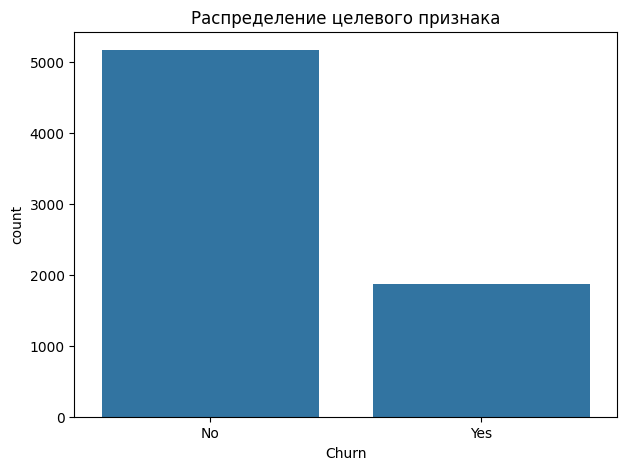

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))

sns.countplot(df, x='Churn')
plt.title('Распределение целевого признака')
plt.show()


вывод - классы и правда не сбалансированны

### Распределение признаков

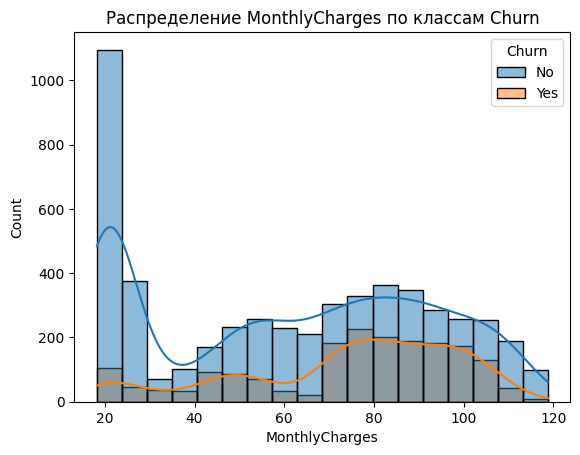

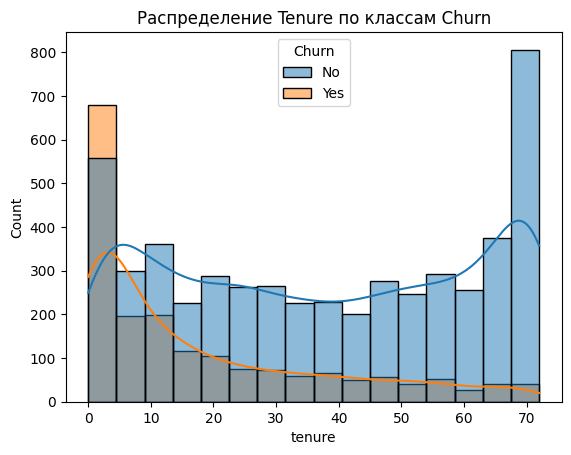

In [4]:
# ежемесячные платежеи по классам
sns.histplot(df, x='MonthlyCharges', hue='Churn', kde=True)
plt.title('Распределение MonthlyCharges по классам Churn')
plt.show()

# срок использования услуг по классам
sns.histplot(df, x='tenure', hue='Churn', kde=True)
plt.title('Распределение Tenure по классам Churn')
plt.show()


вывод - очень большой отток среди новых клиентов

### Корреляции


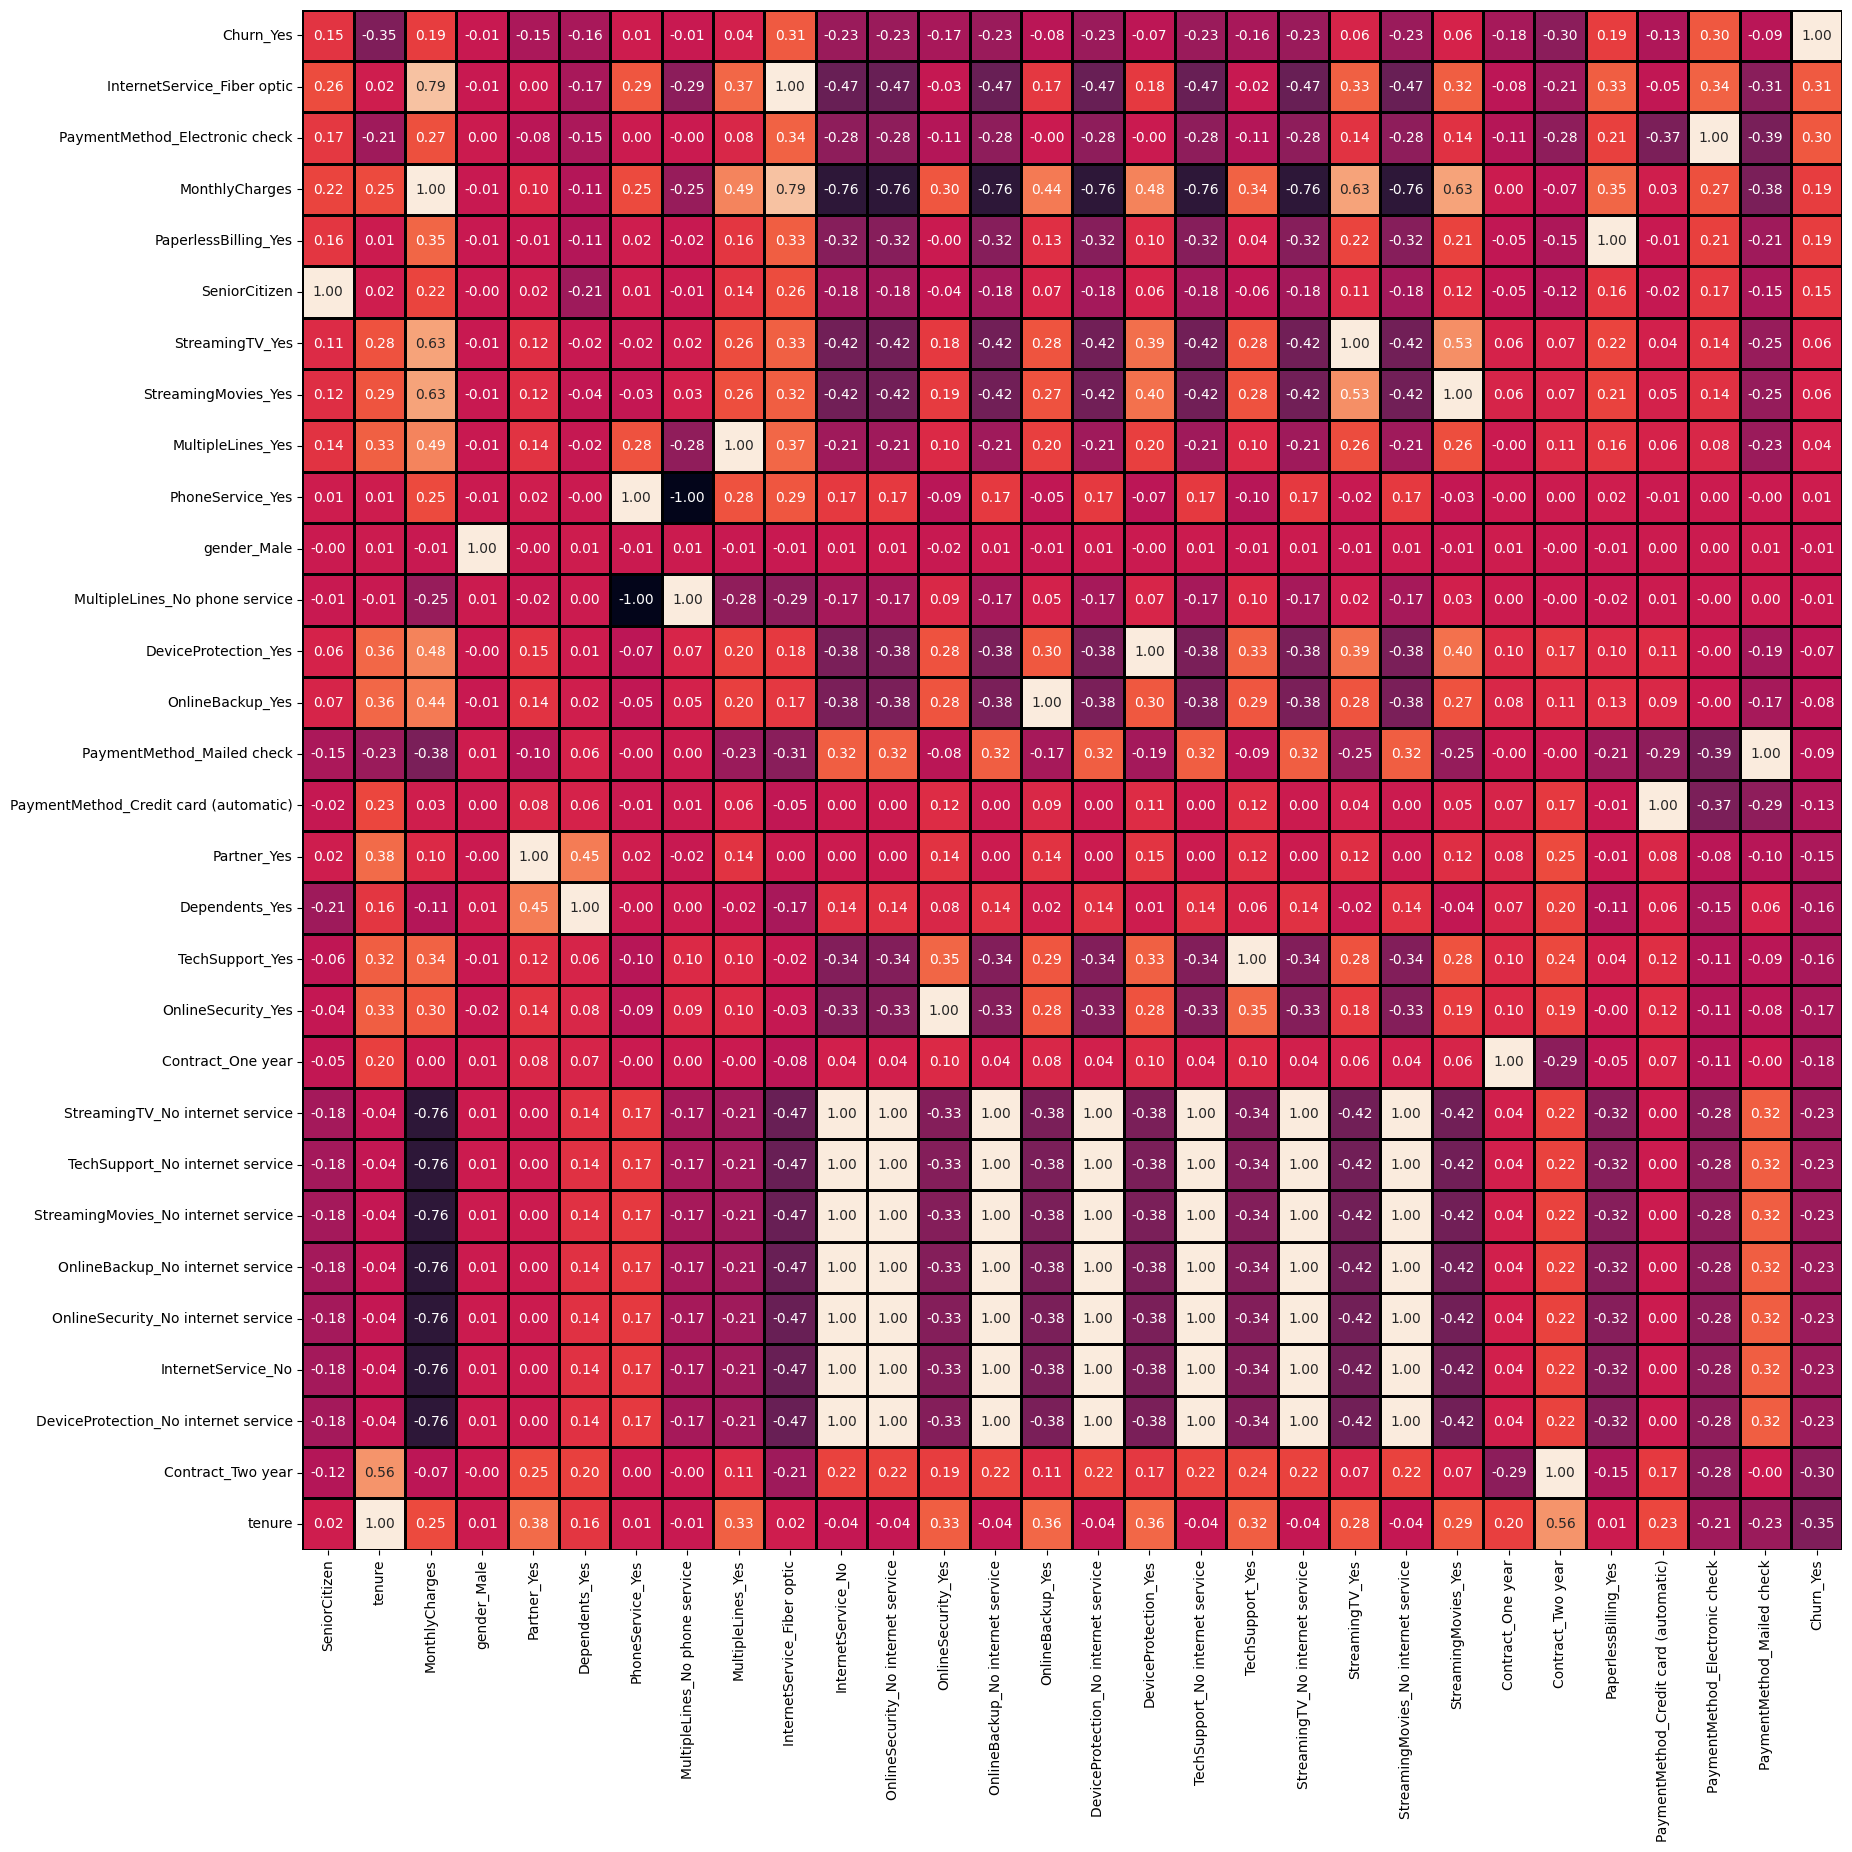

In [5]:
plt.figure(figsize=(20, 20))

df_numeric = df.select_dtypes(include=['number'])
df_reduced = pd.get_dummies(df[[col for col in df.select_dtypes(include=['object']) \
                                if df[col].nunique() < 5]], drop_first=True)

df_final = pd.concat([df_numeric, df_reduced], axis=1)

sns.heatmap(df_final.corr().sort_values(by="Churn_Yes", ascending=False), annot=True, fmt=".2f", linewidths=1, linecolor="black",square=True, cbar=False)
plt.show()


### Аналитика по графикам.

По первым двум графикам можно смело сказать:
- Новые клиенты (<10 мес) сильно склонны к оттоку.
- Более старый клиент = менее склонен к оттоку.

Вывод : `стоит работать с клиентами 0-20 месяцев обслуживания`.

По матрице корреляций:
- Сильные факторы:
    - Срок подписки *(-.35)*. тот же тезис, что и по первым друм графикам
    - Годовые и двухлетние контракты *(-.18 и -.30 соответственно)* помогают удержать клиентов. 
- Умеренные факторы:
    - Месячная плата *(.19)*. тот же тезис, что и по первым двум графикам
    - Способ оплаты *(.17)* - клиенты чаще уходят, если оплачивают безбумажными методами. возможно, клиентам без подключенного интернета не стоит предлагать этот метод оплаты.
- Слабые факторы (что можно не учитывать):
    - Пол клиенты *(.02)*
    - Пожилые клиенты *(.15)* - не значительное влияние.
    - Наличие телефонии *(-.01)*
    - Подписки на стриминги/каналы/кабельное *(.06)*

При дальнешейем анализе стоит изучить - почему у способа оплаты умеренная корреляция к сохранению клиента и как оставить новых клиентов.